# Neural Net testing

In [1]:
import numpy as np                                                              
import matplotlib.pyplot as plt
%matplotlib inline
from functools import reduce

import neuralNet as nn
import utils as u

## MNIST

In [2]:
from torchvision import datasets
train_dataset = datasets.MNIST('./data', train=True, download=True)
test_dataset = datasets.MNIST('./data', train=False, download=True)
X = train_dataset.data.numpy()
Y = train_dataset.targets.numpy()
tX = test_dataset.data.numpy()
tY = test_dataset.targets.numpy()

X = X.reshape([X.shape[0], -1]).astype(np.float64)
tX = tX.reshape([tX.shape[0], -1]).astype(np.float64)
Y = u.onehot(Y)
tY = u.onehot(tY)

In [3]:
w_init = 0.01 #lambda l,l_p1: 0.01 * (np.random.randn(l, l_p1).squeeze() * np.sqrt(2/l)) 
clf = nn.NeuralNet(sizes=[X.shape[1], 100, 10], eta=1e-4, loss='categorical', nonLin=['relu','softmax'],
                     w_init = w_init)
it, E_ins = clf.fit(X, Y, maxIters=3, trackE_in=True, print_stuff=True)

Epoch 1: training loss = 0.15295155971230928
Epoch 2: training loss = 0.10309661600931096
Epoch 3: training loss = 0.1826813217676189


Accuracy: 0.9417


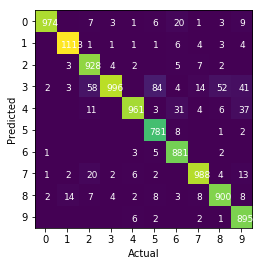

In [4]:
preds = clf(tX)
grid = u.confusions(preds, tY).astype(int)
u.plot_confusions(grid)
print(f'Accuracy: {1 - u.error_rate(preds, tY)}')

In [5]:
u.perf_metric(preds, tY, 'recall')

array([0.99387753, 0.98061675, 0.8992248 , 0.98613864, 0.97861505,
       0.8755605 , 0.9196242 , 0.9610895 , 0.92402464, 0.88701683],
      dtype=float32)

In [6]:
clf.nWeights

79400

# Softmax Test

In [7]:
f, line1 = u.genF(zero_one=True) # We want labels to be 0/1 not -1/1
X, Y = u.genData(f, 50)

In [10]:
def nn_plot_helper(model, X, Y, E_ins, line1, transform = lambda w: [*w[0][1:], w[0][0]]):
    fig, ax = plt.subplots(2, 1, figsize=(8,8))
    u.plotE_ins(E_ins, axis=ax[0])
    u.plotLine(*line1, axis=ax[1], label='Target')
    u.plotLine(*transform(model._weights), color='g', \
                axis=ax[1], label='Hypothesis')
    u.quickScatter(X, Y, axis=ax[1])
    ax[1].set_xlim([-1, 1]); ax[1].set_ylim([-1, 1])
    return ax

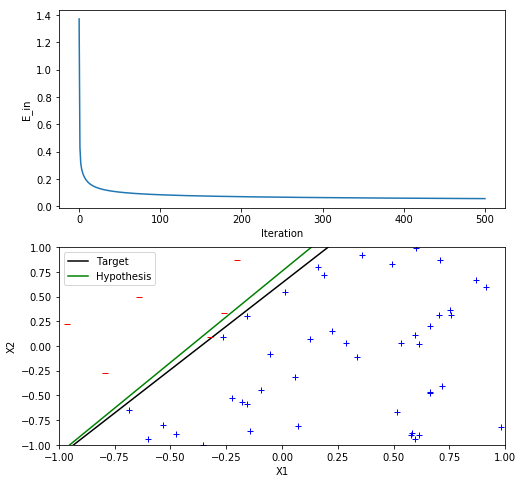

In [11]:
model = nn.NeuralNet(sizes=[3, 1], loss='log', nonLin='sigmoid')
it, E_ins = model.fit(X, Y, maxIters=500, trackE_in=True)
nn_plot_helper(model, X, Y, E_ins, line1);

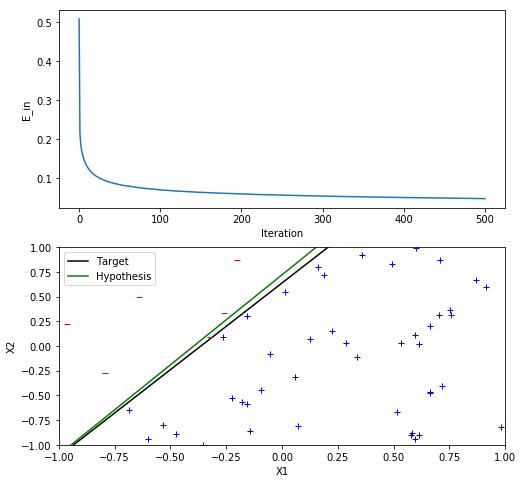

In [12]:
def transform(w):
    w_p = w[0][:, 0] - w[0][:, 1]
    return [*w_p[1:], w_p[0]]
    
model2 = nn.NeuralNet(sizes=[3, 2], loss='categorical', nonLin='softmax')
it, E_ins = model2.fit(X, u.onehot(Y), maxIters=500, trackE_in=True)
nn_plot_helper(model2, X, Y, E_ins, line1, transform = transform);

## One variable function testing

In [13]:
testFunc = lambda x: np.sin(2 * x)

inputs = np.linspace(-np.pi, np.pi, 200)
outputs = testFunc(inputs)

sizes = [1, 100, 100, 1]

## For cosine, need different nonlinearity
#model = nn.NeuralNet(sizes, nonLin='sigmoid')
model = nn.NeuralNet(sizes, nonLin='tanh')

it, E_ins = model.fit(inputs, outputs, maxIters=1000, trackE_in=True)

/Users/akshayyeluri/anaconda3/envs/neural/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


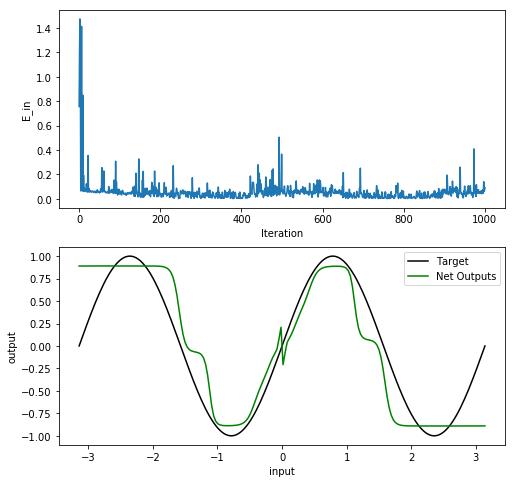

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8))

u.plotE_ins(E_ins, axis=ax[0])
ax[1].plot(inputs, outputs, label='Target', color='k')
ax[1].plot(inputs, model(inputs), \
           color='g', label='Net Outputs')
ax[1].set_xlabel('input'); ax[1].set_ylabel('output'); ax[1].legend()

fig.show()

## Multi-Variable Function Testing

In [15]:
testFunc = lambda x, y: np.cos(x + y)

inputs = np.linspace(-np.pi / 2, np.pi / 2, 100)
inputs = np.vstack((inputs / 3, inputs * 2 / 3)).T
outputs = testFunc(inputs[:, 0], inputs[:, 1])

sizes = [2, 100, 100, 1]

model = nn.NeuralNet(sizes, nonLin='sigmoid')
#model = nn.NeuralNet(sizes)

it, E_ins = model.fit(inputs, outputs, maxIters=1000, trackE_in=True)

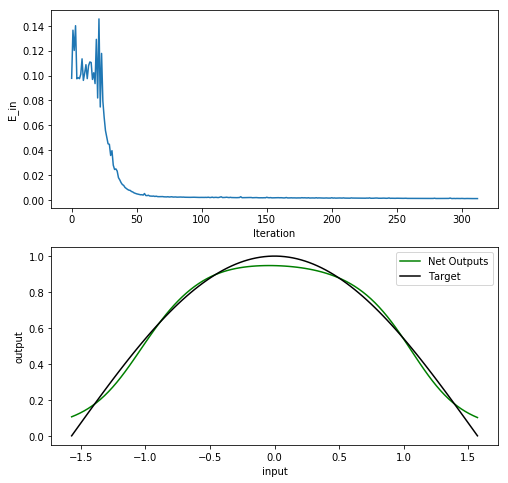

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8))

u.plotE_ins(E_ins, axis=ax[0])

ax[1].plot(np.sum(inputs, axis=1), model(inputs), color='g', label='Net Outputs')
ax[1].plot(np.sum(inputs, axis=1), outputs, color='k', label='Target')
ax[1].set_xlabel('input')
ax[1].set_ylabel('output')
ax[1].legend()

fig.show()

# XOR (doesn't work super well)

In [17]:
testFunc = lambda x: np.sum(np.atleast_2d(x), axis=1) % 2

n_max = 2048
nDigs = len(bin(n_max)[2:])
inputs = np.array([[int(i) for i in list(bin(x)[2:].zfill(nDigs))] for x in range(n_max)])
outputs = testFunc(inputs)

sizes = [nDigs, 100, 1]

model = nn.NeuralNet(sizes, loss='log', nonLin='sigmoid', w_init=10)

it, E_ins = model.fit(inputs, outputs, maxIters=90, trackE_in=True)

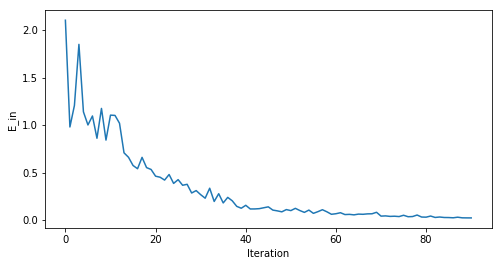

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
u.plotE_ins(E_ins, axis=ax)
fig.show()

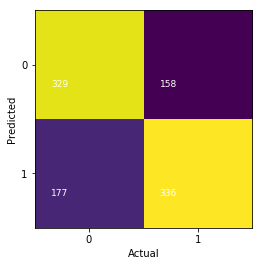

In [19]:
n = 1000
X = np.random.randint(2, size=(n, nDigs))
Y = np.mod(np.sum(X, axis=1), 2)

Y_hat = np.round(model(X))
grid = u.confusions(u.onehot(Y_hat), u.onehot(Y))
u.plot_confusions(grid);